# Images classification between - cats, dogs, and monkeys
## Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


In [3]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

## Step 2 - Download images of cats, dogs, and monkeys

In [4]:
# Imports
from fastai.vision.all import *
from fastcore.all import *
from duckduckgo_search import ddg_images

In [5]:
def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
# ! rm -r /kaggle/working/class_or_not
# ! rm  /kaggle/working/*.jpg

In [7]:
# Get a cat photo
urls = search_images('cat photo', max_images=1)
urls[0]

Searching for 'cat photo'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://static.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg'

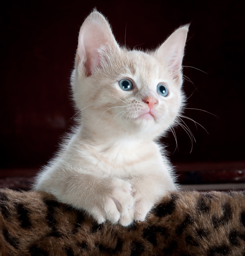

In [8]:
from fastdownload import download_url
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'dog photo'


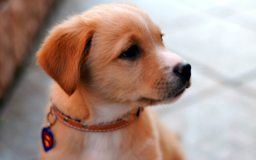

In [9]:
# Get a dog photo and download it
download_url(search_images('dog photo', max_images=5)[2], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

Searching for 'monkey phots'


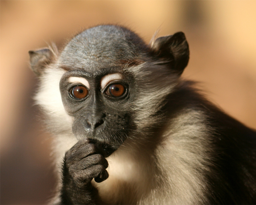

In [10]:
# Get a monkey photo and download it
# Getting more monkey images and choosing one with just 1 monkey
download_url(search_images('monkey phots', max_images=5)[2], 'monkey.jpg', show_progress=False)
Image.open('monkey.jpg').to_thumb(256,256)

In [11]:
# Now get photos of cat, dog and monkey and others like forest
searches = 'cat','dog', 'monkey', 'forest' 
path = Path('photos')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server  
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cat photo'
Searching for 'dog photo'
Searching for 'monkey photo'
Searching for 'forest photo'


## Step 3 - Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

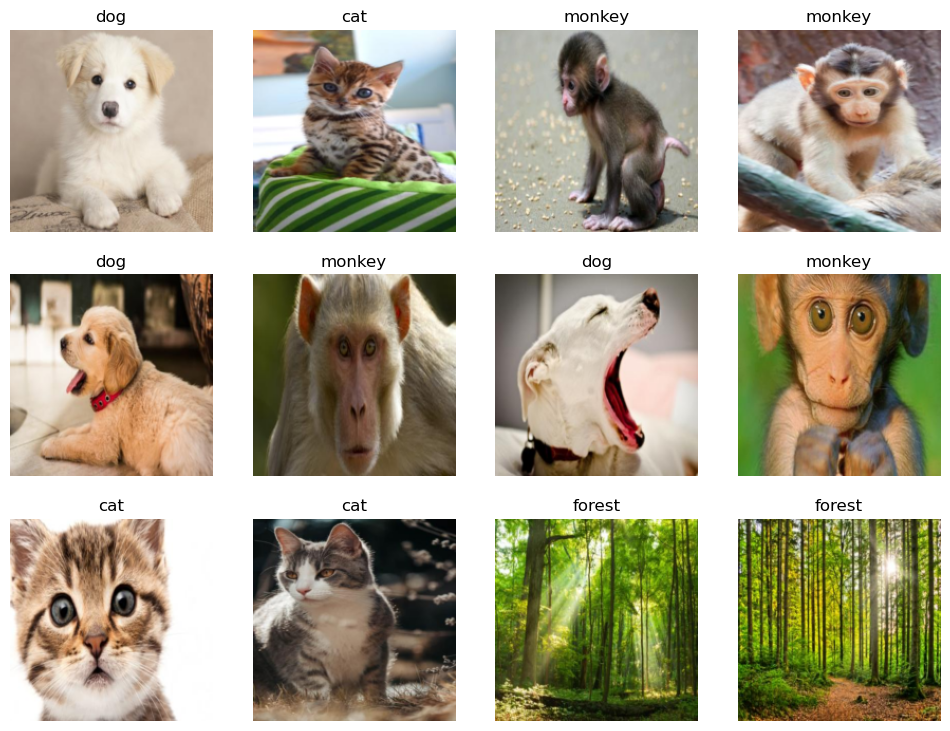

In [13]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
# for 20 epochs as its a more complicated classifictaion as just between bird and forest
learn.fine_tune(20) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.345997,0.462463,0.138889,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.341948,0.195493,0.055556,00:11
1,0.285124,0.117677,0.055556,00:11
2,0.207059,0.071883,0.027778,00:11
3,0.171766,0.050009,0.027778,00:11
4,0.135875,0.041030,0.027778,00:11
5,0.115123,0.035617,0.027778,00:11
6,0.094604,0.045136,0.027778,00:11
7,0.079580,0.053765,0.027778,00:11
8,0.067810,0.060174,0.027778,00:11
9,0.059111,0.058636,0.027778,00:11


## Step 4: Use our model (and build your own!)

In [15]:
# learn.fine_tune?

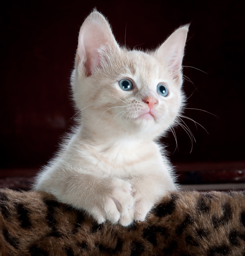

In [16]:
dest = 'cat.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [17]:
#  The predict method returns three things: the decoded prediction (here False for dog), 
# the index of the predicted class and the tensor of probabilities of all classes in the order of their indexed labels
is_cat,index,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[index]:.4f}")

This is a: cat.
Probability it's a cat: 1.0000


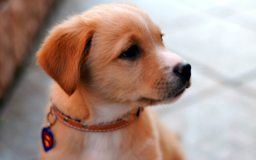

In [18]:
dest = 'dog.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [19]:
is_dog,index,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[index]:.4f}")

This is a: dog.
Probability it's a dog: 1.0000


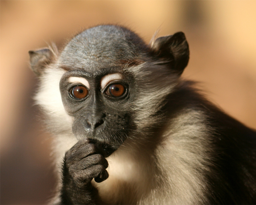

In [20]:
dest = 'monkey.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [21]:
learn.predict??

In [22]:
is_monkey,index,probs = learn.predict(PILImage.create('monkey.jpg'))
print(f"This is a: {is_monkey}.")
print(f"Probability it's a monkey: {probs[index]:.4f}")

This is a: monkey.
Probability it's a monkey: 1.0000
